In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.qc import *
from src.energy_calculation import *
from src.utils import write_to_csv 
sns.set_theme(font_scale=1.5)
from tqdm import tqdm
import tikzplotlib
from scipy.optimize import minimize
import pandas as pd

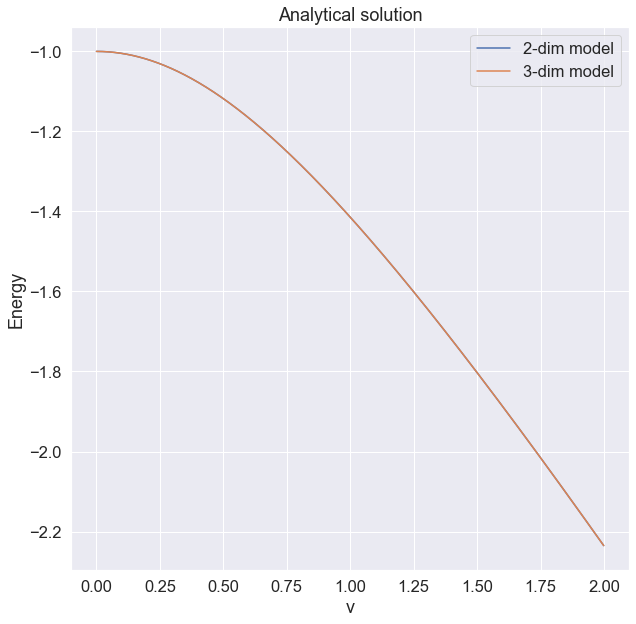

In [2]:
def Hamiltonian(v):    
    # qb = One_qubit()
    # H = 0.5*(np.kron(qb.Z, qb.I) + np.kron(qb.I, qb.Z)) - \
    #     v/2 * (np.kron(qb.X, qb.X) - np.kron(qb.Y, qb.Y))
    H = np.array([[1, 0, -v], [0, 0, 0], [-v, 0, -1]])
    return H

v_vals_ana = np.arange(0, 2, 0.001)
eigvals_ana = np.zeros((len(v_vals_ana), 3))
eigvals2_ana = np.zeros((len(v_vals_ana), 2))
entropy = np.zeros((len(v_vals_ana), 3))
qb = Qubit(1)
Z, X = qb.Z, qb.X
for index, v in enumerate(v_vals_ana):
    H = Hamiltonian(v)
    H2 = -Z - v*X
    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()
    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]
    eigen, eigvecs = np.linalg.eig(H2)
    permute = eigen.argsort()
    eigvals2_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.plot(v_vals_ana, eigvals_ana[:,0], label='2-dim model')
axs.plot(v_vals_ana, eigvals2_ana[:,0], label='3-dim model')
axs.set_xlabel('v')
axs.set_ylabel('Energy')
axs.set_title('Analytical solution')
axs.legend()


In [3]:
#coupled spin mapping (1 qubit)
qb = Qubit(1)
I, X, Y, Z, S, H, SWAP, CNOT10 = qb.I, qb.X, qb.Y, qb.Z, qb.S, qb.H, qb.SWAP, qb.CNOT10
Sdag = S.conj().T
unitaries = [I, H]

number_shots = 20_000
v_vals = np.linspace(0.0, 2.0, 11)
min_energy_coupled = np.zeros(len(v_vals))
for index, v in enumerate(tqdm(v_vals)):
    constants = np.array([-1, -v])
    const_term = None 
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 2)
    args = (number_shots, unitaries, prepare_state_1D, constants, const_term)
    res = minimize(get_energy, angles_start, args = args, method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_coupled[index] = res.fun

write_to_csv(v_vals, min_energy_coupled, header='v,energy', filename='../data/Lipkin_J=1_coupled')

100%|██████████| 11/11 [00:02<00:00,  5.46it/s]


In [4]:
# individual spin mapping (2 qubits)
qb = Qubit(2)
I, X, Y, Z, S, H, SWAP, CNOT10 = qb.I, qb.X, qb.Y, qb.Z, qb.S, qb.H, qb.SWAP, qb.CNOT10
Sdag = S.conj().T
unitaries = [np.kron(I, I), SWAP, CNOT10@np.kron(H, H), CNOT10@np.kron(H@Sdag, H@Sdag)]


number_shots = 10_000
v_vals = np.linspace(0.0, 2.0, 11)
min_energy_individual = np.zeros(len(v_vals))
for index, v in enumerate(tqdm(v_vals)):
    constants = np.array([1/2, 1/2, -v/2, v/2])
    const_term = None 
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    args = (number_shots, unitaries, prepare_state_2D, constants, const_term)
    res = minimize(get_energy, angles_start, args = args, method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_individual[index] = res.fun

write_to_csv(v_vals, min_energy_individual, header='v,energy', filename='../data/Lipkin_J=1_individual')

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


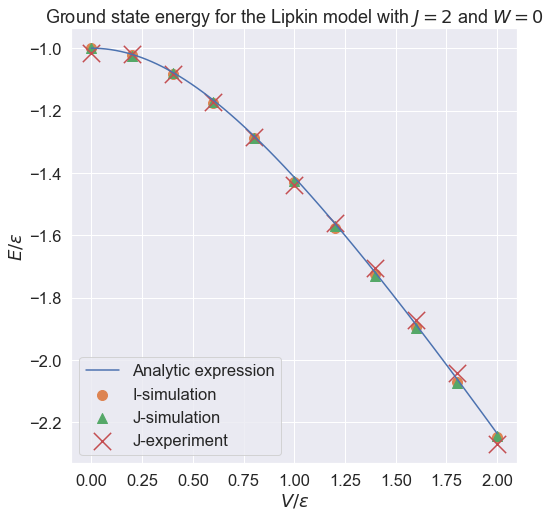

In [6]:
df_ind = pd.read_csv('../data/Lipkin_J=1_individual.csv')
df_coupled = pd.read_csv('../data/Lipkin_J=1_coupled.csv')
df_qiskit = pd.read_csv('../data/Lipkin_J=1_qiskit.csv')

v_vals = df_ind['v'].to_numpy()
min_energy_individual = df_ind['energy'].to_numpy()
min_energy_coupled = df_coupled['energy'].to_numpy()
qiskit_energies = df_qiskit['energy'].to_numpy()

fig, axs = plt.subplots(1, 1, figsize=(8, 8))
# for i in range(len(eigvals_ana[0])):
for i in range(1):
    axs.plot(v_vals_ana, eigvals_ana[:, i], label=f'Analytic expression')
axs.set_xlabel(r'$V/\epsilon$')
axs.scatter(v_vals, min_energy_individual, label = 'I-simulation', color = '#dd8452', marker = 'o', s = 100)
axs.scatter(v_vals, min_energy_coupled, label = 'J-simulation', color = '#55a868', marker = '^', s = 100)
axs.scatter(v_vals, qiskit_energies, label = 'J-experiment', color = '#c44e52', marker = 'x', s = 300)
axs.set_ylabel(r'$E/\epsilon$')
axs.legend(loc = 'lower left')
axs.set_title(r'Ground state energy for the Lipkin model with $J = 2$ and $W = 0$')
tikzplotlib.clean_figure()
tikzplotlib.save(
    f'../plots/lipkin_J=1.tex',
    extra_axis_parameters=[
        'title style={align=center}',
        'xmajorticks=true',
        'ymajorticks=true',
        'mark options={mark size=1.4pt, line width=1.5pt}',
        ],
        strict=True,
    )
plt.show()